# Shallow Learning Model 1 - Logistic Regression 

# Workspace Setup

In [0]:
# Data loading and manipulation
import pandas as pd
import numpy as np

# Seed random number generator
np.random.seed(0)

# Matplotlib for general plotting
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Seaborn for distribution plots
from seaborn import distplot

# Scikit imports - Splitting Data, Cross Validation
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer, log_loss

# Scikit imports - Creating Models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier

# Scikit imports - Classification and Training 
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, \
plot_confusion_matrix

# Functions


## Function 1 - Classification Results

 Uses a classification report, a receiver-operating characteristics curve with its area, and the confusion matrix to summarise classification performance of a model.

In [0]:
def get_classification_result(estimator, X, y_true, classifier_name=None,
                              normalize_conf_mat='all'):
    """Custom function to display classification results"""
    # Predictions will be used several times
    y_pred = estimator.predict(X) 

    # Display the classification report 
    print("CLASSIFICATION REPORT")
    print(classification_report(y_true, y_pred, labels=[0, 1], 
                                target_names=['Regular Consumer', 'Thieves'],))
    
    # Display the confusion matrix
    print("CONFUSION MATRIX")
    normalize=None
    if (normalize_conf_mat=='rows'):
      normalize='true'
    elif (normalize_conf_mat=='cols'):
        normalize='pred'
    else:
      normalize='all'

    # Use built-in function to get confusion matrix for this estimator
    conf_mat_display = plot_confusion_matrix(estimator=estimator, 
                                             X=X, 
                                             y_true=y_true, 
                                             labels=[0, 1],
                                             normalize=normalize, 
                                             display_labels=['Regular Consumers', 'Thieves'], 
                                             cmap=plt.cm.Blues)
    
    # Add a title (with optional classifier name)
    conf_mat_display.ax_.set_title("Confusion Matrix - {}".format(
        classifier_name if classifier_name is not None 
        else 'Test Classifier' ))
    
    # This will render the confusion matrix as an image
    print(conf_mat_display.confusion_matrix);
    plt.grid(False)       # Remove extra lines from confusion matrix
    
    # Display ROC 
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_true, y_pred) 
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(loc='lower right')
    
    if classifier_name is not None:
        plt.title(f'ROC Curve - {classifier_name}', fontsize=14)

In [0]:
def get_keras_classifier_results(model, X, y_true, model_name):
  #

# Importing Data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/final-scaled-data.csv'

In [0]:
data = pd.read_csv(filepath)

In [0]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.315047,0.385712,0.301797,0.461161,0.290756,0.315783,0.372462,0.366573,0.279715,0.669475,0.402274,0.419940,0.733147,0.393809,0.338602,0.249167,0.248799,0.226348,0.239230,0.297381,0.293332,0.324248,0.271249,0.431349,0.405586,0.301061,0.269777,0.246958,0.313575,0.232237,0.264257,0.297013,0.297749,0.350747,0.201689,0.322040,0.342282,0.277506,0.337130,0.248063
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.618551,1.000000,1.000000,1.000000,1.000000,0.944143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.812126,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.619902,0.607360,0.295618,0.815547,0.504163,0.741732,0.232911,0.357966,0.666126,0.601627,0.961027,0.526737,0.575111,0.863563,0.452922,0.388782,0.421748,0.466897,0.439306,0.561137,0.481230,0.538562,0.523512,0.500580,0.539995,0.505596,0.529246,0.419957,0.420315,0.429273,0.459014,0.541787,0.618469,0.534262,0.701958,0.744957,0.643193,0.690133,0.518138,0.419957
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.144169,0.280383,0.347496,0.165048,0.179465,0.265966,0.235144,0.182945,0.175488,0.17002,0.189408,0.227687,0.176979,0.211282,0.1918

## Train-Test Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Extracting features and labels
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

In [0]:
# Stratified random sampling of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

In [0]:
# Confirm one-one correspondence between train and test features and labels
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

## Confirming Stratification in Train/Test Data

In [0]:
from seaborn import barplot

In [0]:
# Dictionaries of raw counts of class labels
raw_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0),
        '1': np.count_nonzero(y_train == 1)
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0),
        '1': np.count_nonzero(y_test == 1)
    }
}

In [0]:
# Repeat for normalized counts
NUM_TRAIN = len(y_train)
NUM_TEST = len(y_test)
NUM_SAMPLES = len(y)

normed_counts = {
    'train': {
        '0': np.count_nonzero(y_train == 0) / NUM_TRAIN,
        '1': np.count_nonzero(y_train == 1) / NUM_TRAIN
    }, 
    'test': {
        '0': np.count_nonzero(y_test == 0) / NUM_TEST,
        '1': np.count_nonzero(y_test == 1) / NUM_TEST
    }
}

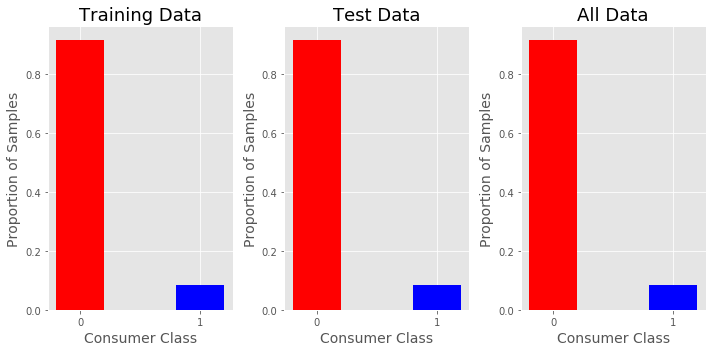

In [0]:
# Comparing train, test, and original data in 3 side-by-side graphs
fig, axes = plt.subplots(ncols=3, figsize=(10, 5), sharey=False)

# First plot - Training Data
plt.sca(axes[0])
plt.bar(x=normed_counts['train'].keys(), height=normed_counts['train'].values(), 
       color=['red', 'blue'], width=0.4)
plt.xlabel('Consumer Class', fontsize=14)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Training Data', fontsize=18)

# Second plot - Test Data
plt.sca(axes[1])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), height=normed_counts['test'].values(), 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('Test Data', fontsize=18)


# Third plot - All data
plt.sca(axes[2])
plt.xlabel('Consumer Class', fontsize=14)
plt.bar(x=normed_counts['test'].keys(), 
       height=[np.count_nonzero(y == 0) / NUM_SAMPLES, 
               np.count_nonzero(y == 1) / NUM_SAMPLES], 
       color=['red', 'blue'], width=0.4)
plt.ylabel('Proportion of Samples', fontsize=14)
plt.title('All Data', fontsize=18)
plt.tight_layout()

# Training Zheng's Logistic Regression Model

Zheng's model specifies L2 regularization with inverse regularization strength of 1.0. 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, learning_curve
from sklearn.metrics import make_scorer, log_loss

In [0]:
# Instantiate a logistic regression model with the specified hyperparameters
logRegZheng = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=500)

In [0]:
# Instantiate a stratified K-Fold Cross Validator for the logRegModel
logRegZhengScores = cross_validate(estimator=logRegZheng, 
                                X=X_train, 
                                y=y_train, 
                                scoring={
                                    'crossentropy': make_scorer(log_loss)},
                                     cv=5,
                                verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


## Exploring `logRegZhengScores`

In [0]:
logRegZhengScores

{'fit_time': array([12.21127653, 12.73287582, 13.84764862, 12.49016142, 13.03085446]),
 'score_time': array([0.0141685 , 0.01610041, 0.01957154, 0.01700187, 0.01492238]),
 'test_crossentropy': array([3.02087551, 2.99540338, 3.06208134, 3.05189034, 3.00094104])}

## Classification Results for this Classifier


In [0]:
logRegZheng.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.43      0.06      0.10       723

        accuracy                           0.91      8475
       macro avg       0.68      0.52      0.53      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX
[[0.91861575 0.56842105]
 [0.08138425 0.43157895]]


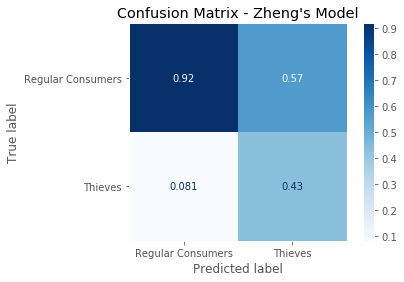

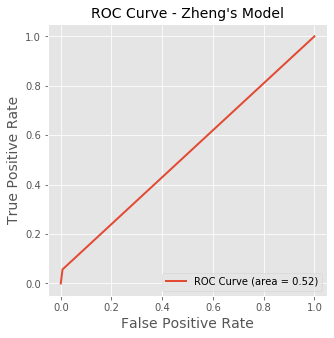

In [0]:
get_classification_result(logRegZheng, X_test, y_test, classifier_name="Zheng's Model", 
                          normalize_conf_mat='cols')

# SGDClassifier

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
sgdZheng = SGDClassifier(loss='log', 
                         penalty='l2', 
                         shuffle=True, 
                         random_state=0, 
                         learning_rate='adaptive',
                         eta0=0.01,
                         validation_fraction=0.2, 
                         alpha=1)

In [0]:
# Instantiate a stratified K-Fold Cross Validator for the logRegModel
logRegZhengScores = cross_validate(estimator=logRegZheng, 
                                X=X_train, 
                                y=y_train, 
                                scoring={
                                    'crossentropy': make_scorer(log_loss)},
                                cv=5,
                                verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


In [0]:
logRegZhengScores

{'fit_time': array([13.37964606, 14.37420011, 13.19492412, 13.05697846, 12.27574515]),
 'score_time': array([0.01402283, 0.01401973, 0.01424789, 0.01390743, 0.01454592]),
 'test_crossentropy': array([3.04125202, 3.05653514, 3.05698684, 3.03660568, 3.0315106 ])}

In [0]:
logRegTest = LogisticRegression(penalty='l2', C=1.0, max_iter=500, 
                                verbose=2, solver='liblinear')

In [0]:
logRegTest.fit(X_train, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.44      0.06      0.10       723

        accuracy                           0.91      8475
       macro avg       0.68      0.52      0.53      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7701,51
True 1,683,40


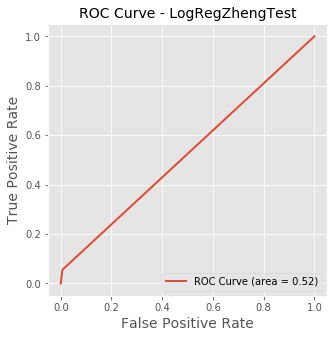

In [0]:
get_classification_result(logRegTest.predict(X_test), 
                          y_true=y_test, classifier_name='LogRegZhengTest')

In [0]:
sgdClassifier = SGDClassifier(loss='log', penalty='l2')

In [0]:
sgdClassifier.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.40      0.08      0.14       723

        accuracy                           0.91      8475
       macro avg       0.66      0.54      0.54      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7665,87
True 1,664,59


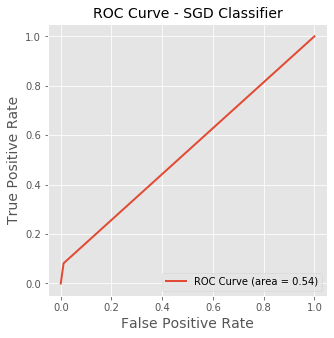

In [0]:
get_classification_result(sgdClassifier.predict(X_test), y_test, classifier_name='SGD Classifier')

# Grid Search Cross Validation

In [0]:
from sklearn.linear_model import LogisticRegressionCV

In [0]:
logRegCV = LogisticRegressionCV(max_iter=500, solver='liblinear', 
                                scoring='roc_auc', cv=5, 
                                Cs=[0.01, 0.03, 0.1, 0.3, 1, 3], 
                                verbose=2)

In [0]:
logRegCV.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.7min finished


[LibLinear]

LogisticRegressionCV(Cs=[0.01, 0.03, 0.1, 0.3, 1, 3], class_weight=None, cv=5,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=500, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring='roc_auc', solver='liblinear', tol=0.0001,
                     verbose=2)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      1.00      0.96      7752
         Thieves       0.61      0.04      0.07       723

        accuracy                           0.92      8475
       macro avg       0.77      0.52      0.51      8475
    weighted avg       0.89      0.92      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7735,17
True 1,696,27


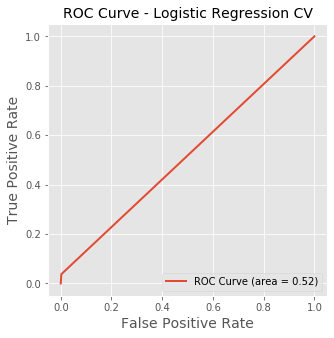

In [0]:
get_classification_result(logRegCV.predict(X_test), y_test, classifier_name='Logistic Regression CV')

# LogReg Without Shuffling

In [0]:
data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.315047,0.385712,0.301797,0.461161,0.290756,0.315783,0.372462,0.366573,0.279715,0.669475,0.402274,0.419940,0.733147,0.393809,0.338602,0.249167,0.248799,0.226348,0.239230,0.297381,0.293332,0.324248,0.271249,0.431349,0.405586,0.301061,0.269777,0.246958,0.313575,0.232237,0.264257,0.297013,0.297749,0.350747,0.201689,0.322040,0.342282,0.277506,0.337130,0.248063
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.618551,1.000000,1.000000,1.000000,1.000000,0.944143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.812126,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.619902,0.607360,0.295618,0.815547,0.504163,0.741732,0.232911,0.357966,0.666126,0.601627,0.961027,0.526737,0.575111,0.863563,0.452922,0.388782,0.421748,0.466897,0.439306,0.561137,0.481230,0.538562,0.523512,0.500580,0.539995,0.505596,0.529246,0.419957,0.420315,0.429273,0.459014,0.541787,0.618469,0.534262,0.701958,0.744957,0.643193,0.690133,0.518138,0.419957
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.144169,0.280383,0.347496,0.165048,0.179465,0.265966,0.235144,0.182945,0.175488,0.17002,0.189408,0.227687,0.176979,0.211282,0.1918

In [0]:
X = data.iloc[:, 2:]
y = data.iloc[:, 1]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=0, 
                                                    stratify=y,
                                                    test_size=0.20)

In [0]:
# Logistic Regression with Zheng's Parameters
logRegClfZheng = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', random_state=0, 
                                    max_iter=1000)

In [0]:
# SGDClassifier
sgdClfZheng = SGDClassifier(loss='log', penalty='l2', max_iter=1000, shuffle=False, 
                            random_state=0, learning_rate='optimal')

In [0]:
# Cross Validating the Logistic Regression Classifier
logRegCVResults = cross_validate(estimator=logRegClfZheng, 
                                 X=X_train,
                                 y=y_train,
                                 scoring='neg_log_loss', 
                                 cv=5,
                                 verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  11.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.2s remaining:    0.0s


[CV] ................................................. , total=  12.4s
[CV]  ................................................................
[CV] ................................................. , total=  13.3s
[CV]  ................................................................
[CV] ................................................. , total=  12.2s
[CV]  ................................................................
[CV] ................................................. , total=  12.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


In [0]:
# Cross Validating the SGDClassifier
sgdClfResults = cross_validate(estimator=sgdClfZheng, 
                               X=X_train, 
                               y=y_train, 
                               scoring='neg_log_loss', 
                               cv=5, 
                               verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s
[CV]  ................................................................
[CV] ................................................. , total=   4.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.1s finished


In [0]:
# Printing log loss results for the logistic regression model
logRegCVResults['test_score']

array([-0.26689756, -0.27205386, -0.28200425, -0.28321308, -0.27842965])

In [0]:
# Printing log loss results for the SGD classifier model
sgdClfResults['test_score']

array([-0.28082786, -0.28519975, -0.30014592, -0.30644884, -1.76853601])

In [0]:
# Train these classifiers on the entire training data
logRegClfZheng.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
sgdClfZheng.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=0, shuffle=False, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.43      0.06      0.10       723

        accuracy                           0.91      8475
       macro avg       0.68      0.52      0.53      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7698,54
True 1,682,41


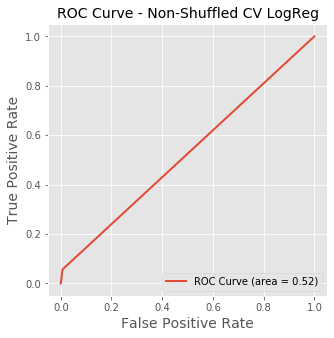

In [0]:
# Visualize results
get_classification_result(logRegClfZheng.predict(X_test), y_test, classifier_name='Non-Shuffled CV LogReg')

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.46      0.05      0.09       723

        accuracy                           0.91      8475
       macro avg       0.69      0.52      0.52      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX


,Predicted 0,Predicted 1
True 0,7708,44
True 1,685,38


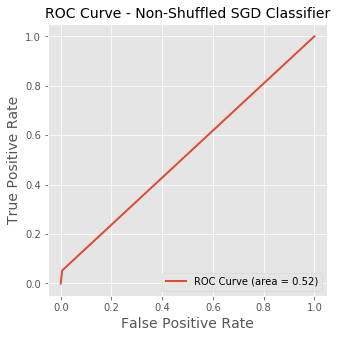

In [0]:
get_classification_result(sgdClfZheng.predict(X_test), y_test, classifier_name='Non-Shuffled SGD Classifier')

In [0]:
logRegTest = LogisticRegression()

In [0]:
coefs = np.random.rand()

# `StandardScaler` Logistic Regression Model

## Importing Data

In [0]:
# Import pre-scaled data with outliers removed
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'
df = pd.read_csv(filepath)

In [256]:
# Checking that data was loaded correctly
df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000



## Visualizing Pre-Scaling Distribution

Text(0.5, 1.0, 'Pre-scaling Distribution of kWhs')

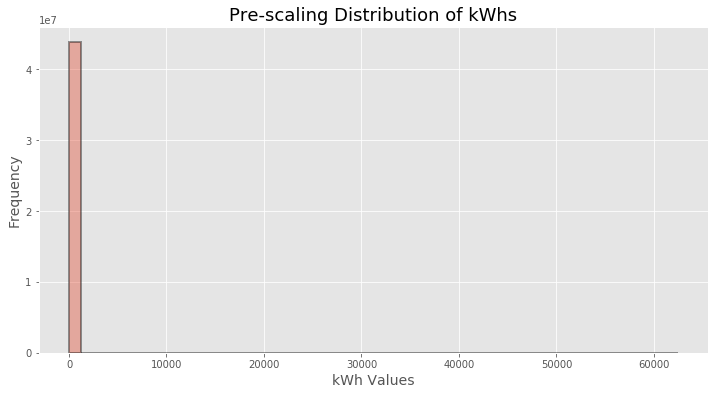

In [4]:
# Confirming the distribution of values is not limited to 0 and 1
plt.figure(figsize=(12, 6))
distplot(df.iloc[:, 2:].values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel("kWh Values", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Pre-scaling Distribution of kWhs", fontsize=18)

Text(0.5, 1.0, 'Pre-scaling Distribution of kWhs')

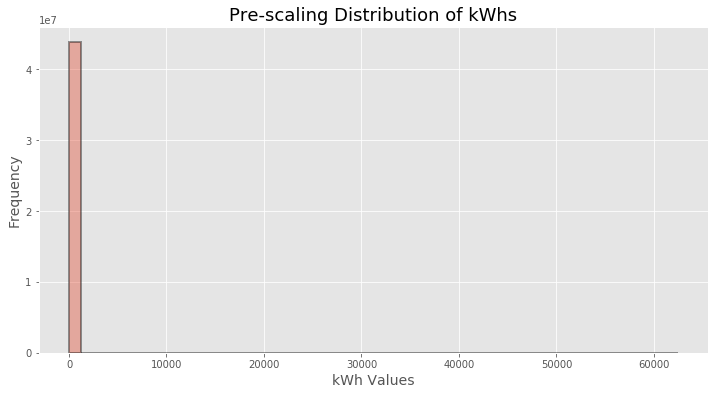

In [5]:
# The data is clearly being skewed by outliers. Examining a smaller region
# Confirming the distribution of values is not limited to 0 and 1
plt.figure(figsize=(12, 6))
distplot(df.iloc[:, 2:].values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel("kWh Values", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Pre-scaling Distribution of kWhs", fontsize=18)

Text(0.5, 1.0, 'Unraveled kWh Values')

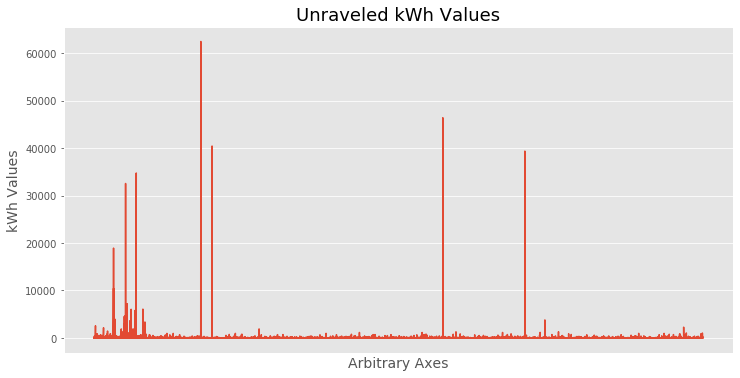

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[:, 2:].values.ravel())
plt.xticks([])
plt.xlabel('Arbitrary Axes', fontsize=14)
plt.ylabel('kWh Values', fontsize=14)
plt.title('Unraveled kWh Values', fontsize=18)

Few outliers, but majority of values are contained within the 0 - 250 kWh region.

## Standardizing by Consumer

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
# Extract the kWhs - copying so that I don't mutate original data
kWhs_unscaled = df.iloc[:, 2:].copy()

In [136]:
kWhs_unscaled.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,2014-02-08,2014-02-09,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,6.73,6.97,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


In [0]:
# Instantiate a StandardScaler
standardScaler = StandardScaler()

In [0]:
# Fit the standard scaler ton a consumer basis by transposing the kWhs
kWhs_scaled = standardScaler.fit_transform(kWhs_unscaled.transpose()).transpose()

In [261]:
# Confirming shape is as expected
kWhs_scaled.shape

(42372, 1034)

In [0]:
# Making a new dataframe
df_std_scaled = df.copy()

In [0]:
# Replacing kWhs with scaled version
df_std_scaled.iloc[:, 2:] = kWhs_scaled

In [264]:
# Confirming shape is as expected
df_std_scaled.shape

(42372, 1036)

## Visualizing Post-Scaling Distribution

Text(0.5, 1.0, 'Feature Values after Standard Scaler')

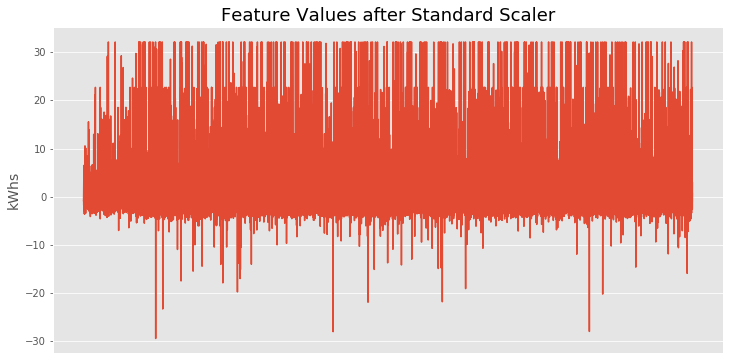

In [81]:
# Checking distribution of kWhs after scaling
plt.figure(figsize=(12, 6))
plt.plot(kWhs_scaled.ravel())
plt.xticks([])
plt.ylabel("kWhs", fontsize=14)
plt.title("Feature Values after Standard Scaler", fontsize=18)

Text(0.5, 1.0, 'Distribution of kWh Values\nAfter Standard Scaler')

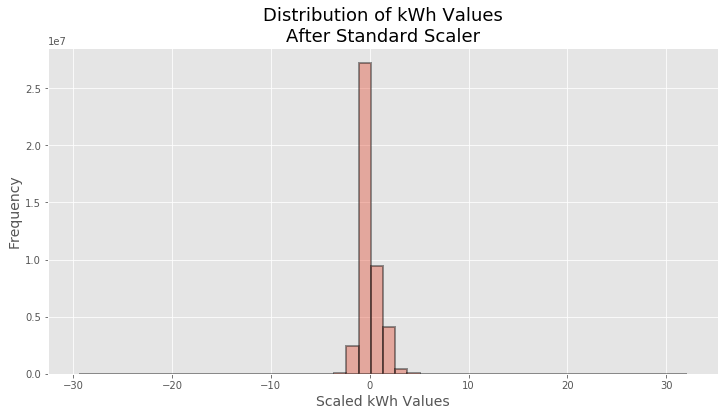

In [265]:
plt.figure(figsize=(12, 6))
distplot(kWhs_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel('Scaled kWh Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title("Distribution of kWh Values\nAfter Standard Scaler", fontsize=18)

In [0]:
# Comparing a random consumer before and after scaling
CONS_INDEX = 1234
scaled_kWhs = df_std_scaled.iloc[CONS_INDEX, 2:]
original_kWhs = df.iloc[CONS_INDEX, 2:]

assert len(scaled_kWhs) == len(original_kWhs)

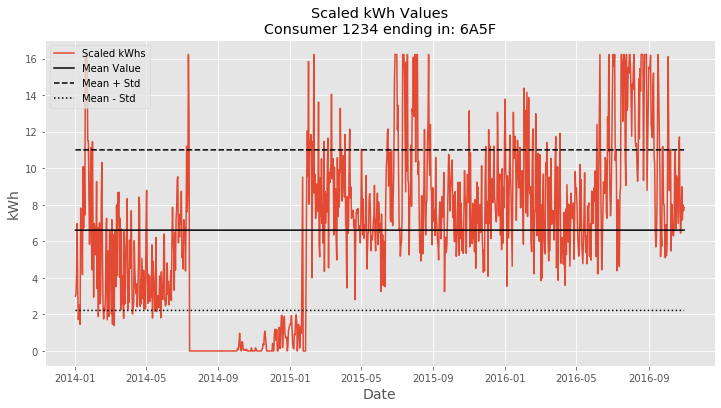

In [97]:
plt.figure(figsize=(12, 6))
dates = pd.DatetimeIndex(df.columns[2:])
mean_threshold = np.ones((len(original_kWhs), 1)) * original_kWhs.mean()
std_threshold = np.ones((len(original_kWhs), 1)) * original_kWhs.std()
plt.plot(dates, original_kWhs, label='Scaled kWhs')
plt.plot(dates, mean_threshold, 'k', label='Mean Value')
plt.plot(dates, mean_threshold + std_threshold, 'k--', label='Mean + Std')
plt.plot(dates, mean_threshold - std_threshold, 'k:', label='Mean - Std')
plt.xlabel("Date", fontsize=14)
plt.ylabel("kWh", fontsize=14) 
plt.title(f"Scaled kWh Values\nConsumer {CONS_INDEX} ending in: {df.iloc[CONS_INDEX, 0][-5:-1]}")
plt.legend()

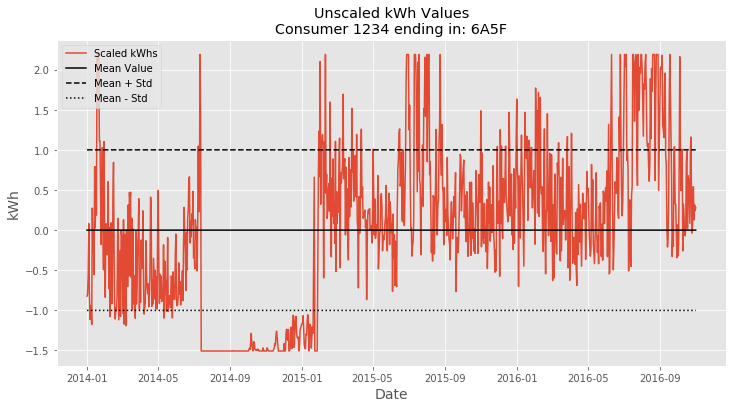

In [99]:
# Plotting the original data for this consumer
plt.figure(figsize=(12, 6))
dates = pd.DatetimeIndex(df.columns[2:])
mean_threshold = np.ones((len(scaled_kWhs), 1)) * scaled_kWhs.mean()
std_threshold = np.ones((len(scaled_kWhs), 1)) * scaled_kWhs.std()
plt.plot(dates, scaled_kWhs, label='Scaled kWhs')
plt.plot(dates, mean_threshold, 'k', label='Mean Value')
plt.plot(dates, mean_threshold + std_threshold, 'k--', label='Mean + Std')
plt.plot(dates, mean_threshold - std_threshold, 'k:', label='Mean - Std')
plt.xlabel("Date", fontsize=14)
plt.ylabel("kWh", fontsize=14) 
plt.title(f"Unscaled kWh Values\nConsumer {CONS_INDEX} ending in: {df.iloc[CONS_INDEX, 0][-5:-1]}")
plt.legend()

## Train-Test Split

In [0]:
# Extracting features and labels
X = df_std_scaled.iloc[:, 2:]
y = df_std_scaled.iloc[:, 1]

In [269]:
# Confirming shapes
print("Shape of features matrix: ", X.shape)
print("Shape of labels matrix: ", y.shape)

Shape of features matrix:  (42372, 1034)
Shape of labels matrix:  (42372,)


In [0]:
# Stratified random sampling of training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    stratify=y)

## Cross-Validating Model

In [0]:
# Cross Validating on Training Set
logRegStd = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', 
                                     max_iter=500)

In [148]:
# First explore cross validation fold scores
logRegStdScores = cross_validate(estimator=logRegStd, 
                                 X=X_train,
                                 y=y_train, 
                                 scoring='neg_log_loss',
                                 cv=5, 
                                 verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  23.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.6s remaining:    0.0s


[CV] ................................................. , total=  19.7s
[CV]  ................................................................
[CV] ................................................. , total=  18.8s
[CV]  ................................................................
[CV] ................................................. , total=  18.5s
[CV]  ................................................................
[CV] ................................................. , total=  19.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.7min finished


## Cross Validation Scores

In [149]:
# Did it have any effect on log loss?
logRegStdScores['test_score']

array([-0.27357219, -0.28106377, -0.28511293, -0.2904709 , -0.28348817])

# `MinMax` Scaling

## Importing Data

In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/final-scaled-data.csv'

In [0]:
df_minmax = pd.read_csv(filepath)

In [179]:
df_minmax.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.315047,0.385712,0.301797,0.461161,0.290756,0.315783,0.372462,0.366573,0.279715,0.669475,0.402274,0.419940,0.733147,0.393809,0.338602,0.249167,0.248799,0.226348,0.239230,0.297381,0.293332,0.324248,0.271249,0.431349,0.405586,0.301061,0.269777,0.246958,0.313575,0.232237,0.264257,0.297013,0.297749,0.350747,0.201689,0.322040,0.342282,0.277506,0.337130,0.248063
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.618551,1.000000,1.000000,1.000000,1.000000,0.944143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.812126,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,...,0.619902,0.607360,0.295618,0.815547,0.504163,0.741732,0.232911,0.357966,0.666126,0.601627,0.961027,0.526737,0.575111,0.863563,0.452922,0.388782,0.421748,0.466897,0.439306,0.561137,0.481230,0.538562,0.523512,0.500580,0.539995,0.505596,0.529246,0.419957,0.420315,0.429273,0.459014,0.541787,0.618469,0.534262,0.701958,0.744957,0.643193,0.690133,0.518138,0.419957
4,EDFC78B07BA2908B3395C4EB2304665E,1,0.144169,0.280383,0.347496,0.165048,0.179465,0.265966,0.235144,0.182945,0.175488,0.17002,0.189408,0.227687,0.176979,0.211282,0.1918

In [0]:
# Extracting features and labels
X = df_minmax.iloc[:, 2:]
y = df_minmax.iloc[:, 1]

## Visualizing Distribution of Features

Text(0.5, 1.0, 'Distribution of kWh Values\nMinMax Scaling')

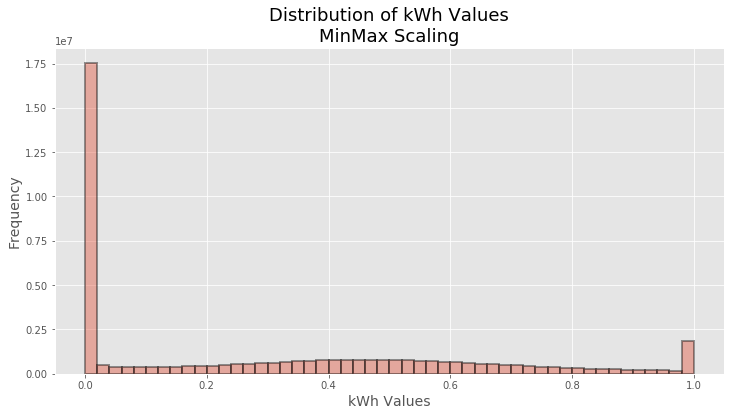

In [182]:
plt.figure(figsize=(12, 6))
distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
plt.xlabel('kWh Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of kWh Values\nMinMax Scaling', fontsize=18)

## Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20, 
                                                    random_state=0, 
                                                    stratify=y)

## Cross-Validating Model

In [0]:
# Instantiate a Logistic Regression model with same hyperparams
logRegMinMax = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)

In [185]:
# Cross validate on the training data with 5 folds and log loss 
logRegMinMaxScores = cross_validate(estimator=logRegMinMax, 
                                    X=X_train,
                                    y=y_train, 
                                    scoring='neg_log_loss', 
                                    cv=5, 
                                    verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  11.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s


[CV] ................................................. , total=  13.0s
[CV]  ................................................................
[CV] ................................................. , total=  14.3s
[CV]  ................................................................
[CV] ................................................. , total=  12.5s
[CV]  ................................................................
[CV] ................................................. , total=  13.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


## Cross Validation Scores

In [163]:
# Echo results of this model's cross validation
logRegMinMaxScores['test_score']

array([-0.26689756, -0.27205386, -0.28200425, -0.28321308, -0.27842965])

# Comparing Effect of Scaling Strategy on Log Loss

In [0]:
# Extract the validation set scores
minMaxScores = logRegMinMaxScores['test_score']
stdScores = logRegStdScores['test_score']

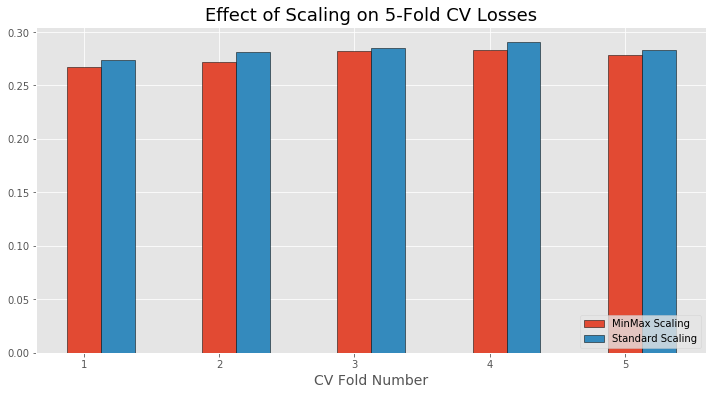

In [165]:
# Plotting a grouped bar chart to compare the log loss of standard and minmax scaling
barWidth = 0.25 

minMaxTicks = np.arange(1, len(minMaxScores) + 1, 1)
stdTicks = [x + barWidth for x in minMaxTicks]

plt.figure(figsize=(12, 6))
plt.bar(minMaxTicks, -1 * minMaxScores, width=barWidth, edgecolor='k', label='MinMax Scaling')
plt.bar(stdTicks, -1 * stdScores, width=barWidth, edgecolor='k', label='Standard Scaling')
plt.xlabel('CV Fold Number', fontsize=14)
plt.title("Effect of Scaling on 5-Fold CV Losses", fontsize=18)

plt.legend(loc='lower right')

`MinMax` scaling gives a marginally lower log loss than `StandardScaler` for all cross validation folds.

# Test Set Results

## `StandardScaler` Model

In [151]:
# Must fit on entire training set before validating
logRegStd.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.93      0.99      0.96      7752
         Thieves       0.79      0.23      0.36       723

        accuracy                           0.93      8475
       macro avg       0.86      0.61      0.66      8475
    weighted avg       0.92      0.93      0.91      8475

CONFUSION MATRIX
[[0.90938053 0.00530973]
 [0.06536873 0.019941  ]]


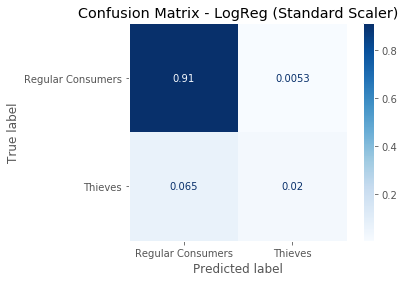

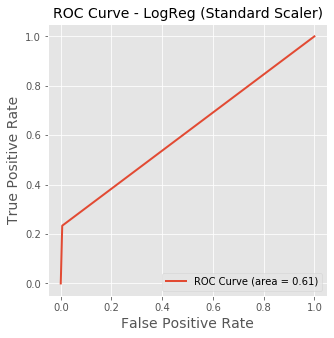

In [155]:
get_classification_result(estimator=logRegStd, X=X_test, 
                          y_true=y_test, classifier_name='LogReg (Standard Scaler)')

## `MinMax` Model

In [189]:
# Must fit on the entire training set before testing
logRegMinMax.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.92      0.99      0.95      7752
         Thieves       0.43      0.06      0.10       723

        accuracy                           0.91      8475
       macro avg       0.68      0.52      0.53      8475
    weighted avg       0.88      0.91      0.88      8475

CONFUSION MATRIX
[[0.90831858 0.00637168]
 [0.08047198 0.00483776]]


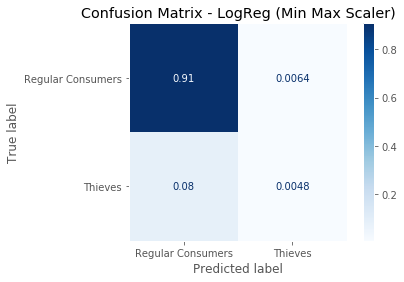

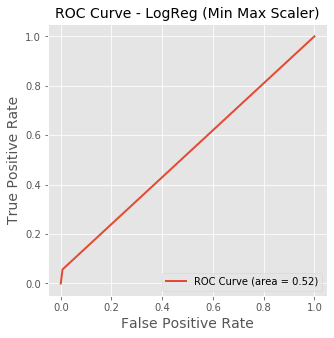

In [190]:
# How does it perform on the test set?
get_classification_result(estimator=logRegMinMax, X=X_test, 
                          y_true=y_test, classifier_name='LogReg (Min Max Scaler)')

# Results
- Changing feature scaler from `MinMaxScaler` to `StanardScaler` had a marked effect on classifier AUC.
- AUC increased from 0.52 with `MinMax` to 0.61 with `StandardScaler`.

# `keras` LogReg w/`StandardScaler`

In [0]:
from keras.models import Sequential
from keras.layers import Dense

## Creating a Model

In [0]:
# Instantiate a model
model = Sequential()

In [0]:
# Single node computes weighted sum of 1034 features as z
# Passes this as argument to `sigmoid` activation function for output
model.add(Dense(input_shape=(1034,), units=1, activation='sigmoid'))

In [254]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 1035      
Total params: 1,035
Trainable params: 1,035
Non-trainable params: 0
_________________________________________________________________


## Compiling Model

In [0]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy')

## Training Model

In [0]:
# Train the model on 
keras_history = model.fit(X_train, y_train, 
          batch_size=128, epochs=50, validation_split=0.2, 
          verbose=1)

## Plotting History

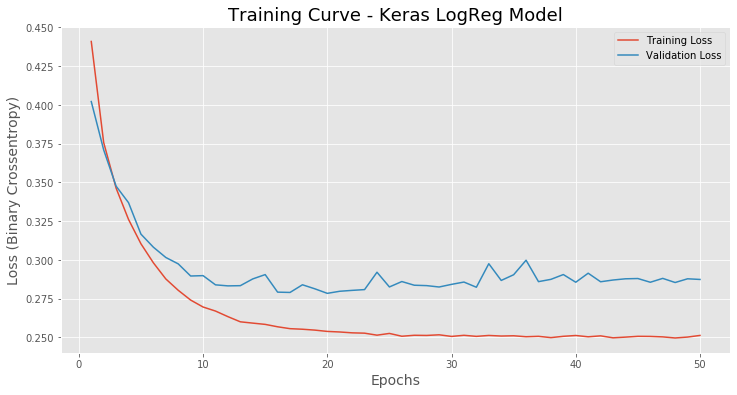

In [274]:
epochs = range(1, len(keras_history.history['loss']) + 1)
loss = keras_history.history['loss']
val_loss = keras_history.history['val_loss']
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss (Binary Crossentropy)', fontsize=14)
plt.title("Training Curve - Keras LogReg Model", fontsize=18)
plt.legend()

## Training Results
Validation scores are between 0.275 and 0.300, which is exactly the same range as the `scikit-learn` `LogisitcRegression` models. 